### LDA topic model
Mihai Matei [Data Science]

#### Module dependencies
Please make sure you have all the dependencies installed. On some platforms pip install might fail.
* randomcolor is used to generate color for plots
* xlrd is needed by panda to read xls files
* statsmodel is needed by pymc.geweke
* wordcloud to do word distribution in topic animation

To run the sanity check as stated in the Project requirement set SANITY to True

Set DOCUMENT_UNIQUE_WORDS to True to remove filtering for unique words in each document

In [1]:
# Download some of the required libraries
import sys
def install_modules():
    """Depending on your platform you might consider installing the below manually"""
    !pip install --quiet kaggle
    !pip install --quiet numpy
    !pip install --quiet matplotlib
    !pip install --quiet randomcolor
    !pip install --quiet nltk
    !pip install --quiet pandas
    !pip install --quiet xlrd
    !pip install --quiet pymc
    !pip install --quiet statsmodels
    !pip install --quiet wordcloud
install_modules()

# This will control the sample size in LDA, CTP, DTM
MASTER_MCMC_SAMPLE=10000

# REPLACE ME - BE KIND
NO_TOPICS = 3
NO_DOCUMENTS = 6

# Set this to True to get unique words in each document
DOCUMENT_UNIQUE_WORDS=False

# Set this to True to run the sanity tests
SANITY=False

#### Download NLTK Reuters News Documents corpus
Create a kaggle account and an API token https://github.com/Kaggle/kaggle-api/blob/master/README.md

Data set: https://www.kaggle.com/boldy717/reutersnltk

In [2]:
%reload_ext autoreload
%autoreload
import sys
import os
import shutil
import numpy as np
import pandas as pd

# Import my own library from local disk or gdrive
GDRIVE_PATH='/content/gdrive/My Drive/master/ProgProb/LDA/'
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/gdrive')
    sys.path.append(GDRIVE_PATH)
    os.makedirs('/root/.kaggle/', exist_ok=True)
    shutil.copyfile(GDRIVE_PATH + 'kaggle.json', '/root/.kaggle/kaggle.json')
    !chmod 600 '/root/.kaggle/kaggle.json'

# Download the NLTK generated database from kaggle
if not os.path.isfile('./data/reutersNLTK.xlsx'):
    import kaggle
    kaggle.api.authenticate()
    kaggle.api.dataset_download_files('boldy717/reutersnltk', path='./data', unzip=True)
    
pDF = pd.read_excel('./data/reutersNLTK.xlsx', index_col=0)
pDF.describe()

,categories,text
count,10788,10788
unique,468,10657
top,['earn'],26-FEB-1987\n 26-FEB-1987\n\n
freq,3923,7


#### Extract topics and documents
Randomly extract a number of unique topics and documents with the selected topics from the dataframe
1. Select K random topics from unique categories in the data set
2. Select N random documents that each have at least one category assigned from the above topics

In [3]:
import ast
import random
from datetime import datetime
MIN_DOCUMENTS_WITH_TOPIC=10

class CorpusSampler(object):
    random.seed(datetime.now())

    def __init__(self, df, topics, no_documents):
        self._df = df
        if isinstance(topics, list):
            self._no_topics = len(topics)
            self._topics = {t : idx for idx, t in enumerate(topics)}
        else:
            self._no_topics = topics
            self._topics = None
        self._no_documents = no_documents
        self._true_topics = None
        self._documents_text = None
        self._min_documents_with_topic = MIN_DOCUMENTS_WITH_TOPIC
    
    @property
    def no_topics(self):
        return self._no_topics
    
    @property
    def no_documents(self):
        return self._no_documents

    @property
    def topics(self):
        return self._topics
    
    @property
    def true_topics(self):
        return self._true_topics

    def get_unique_topics(self):
        """Returns the unique number of topics and their frequency
        """
        topic_lists = self._df['categories'].apply(lambda x : ast.literal_eval(x))
        topic_map = {}
        for topics in topic_lists:
            for topic in topics:
                topic_map[topic] = topic_map.get(topic, 0) + 1
        return topic_map

    def sample_topics(self, min_count=None):
        """Sample K random unique topics with min_count frequency
        """
        if min_count is None:
            min_count = self._min_documents_with_topic
        topic_freq = self.get_unique_topics()
        topics = set()
        for k in range(self._no_topics):
            topic = ''
            while topic in topics or topic_freq.get(topic, 0) < min_count:
                topic = random.choice(list(topic_freq.keys()))
            topics.add(topic)

        self._topics = {t : idx for idx, t in enumerate(topics)}
    
        return self

    def sample_documents(self, min_doc_topics=None, min_common_topics=0):
        """Sample N random documents that contain certain topics
        min_doc_topics controls the minimum amount of documents for each topic
        min_common_topics controls the number of common topics in each document
        """
        topics = set(list(self._topics.keys()))
        if min_doc_topics is None:
            min_doc_topics = int(self._no_documents / len(topics))
        else:
            assert min_doc_topics * len(topics) <= self._no_documents
        # create a panda series with the categories filtered with our selected topics
        topic_series = self._df['categories'].apply(lambda x : set(ast.literal_eval(x)) & topics)
        topic_series = topic_series.apply(lambda x: x if len(x) > min_common_topics else np.nan)
        topic_series = topic_series.dropna()

        # Sample N documents from the filtered data
        document_series = topic_series.sample(self._no_documents - min_doc_topics * len(topics))
        # For each topic sample at least min_doc_topics
        if min_doc_topics > 0:
            for topic in topics:
                document_series = pd.Series.append(document_series,
                                                   topic_series[[topic in s for s in topic_series.values]].sample(min_doc_topics))

        document_series = self._df.loc[document_series.index]
        
        self._true_topics = document_series['categories'].apply(lambda x : ast.literal_eval(x)).values
        for i, topic in enumerate(self._true_topics):
            self._true_topics[i] = np.array(topic)

        self._documents_text = document_series['text'].to_numpy()

        return self

    def __str__(self):
        true_topics = [np.array2string(x) for x in self._true_topics]
        str = 'Number of documents: {}\n'.format(self._no_documents)
        str += 'True topic list for each document(a doc may contain more than 1 topics):\n{}\n'.format("\n".join(true_topics))
        str += 'Chosen topics: {}'.format(list(self.topics.keys()))
        return str

#### Pre process documents
Tokenize the existing documents removing punctuation and words that are very common.

More prunning could be done to reduce the number of word:
* convert to lowercase
* separate all alphanumerical values
* take only words with N characters
* remove words with frequence over X
* remove words that are common in al documents (assume all words are in English - uses nltk stopwords dataset)
* remove words with 2 or less characters
* if DOCUMENT_UNIQUE_WORDS is set take only unique words in each document

Construct the words vocabulary *{name:word_id}* and the document list with the words replaced by their vocabulary identifier.


In [4]:
import nltk

class CorpusTokenizer(CorpusSampler):
    nltk.download('stopwords')
    common_words = set(nltk.corpus.stopwords.words('english'))

    def __init__(self, df, topics, no_documents):
        super(CorpusTokenizer, self).__init__(df, topics, no_documents)
        self._vocabulary = None
        self._documents = None
    
    @property
    def vocabulary(self):
        return self._vocabulary

    @property
    def no_vocabulary(self):
        return len(self._vocabulary)

    @property
    def documents(self):
        return self._documents

    @staticmethod
    def tokenize_doc(doc, ignore_words):
        """Tokenize documents text, removing punctuation"""
        # get lowercase
        doc = doc.lower()

        # only get the full words in plain english, not punctuation
        tokenizer = nltk.tokenize.RegexpTokenizer(r"[a-z'-0-9]+")
        doc_words = tokenizer.tokenize(doc)

        # remove common english words and words less then 2 characters
        return np.array([w for w in doc_words if w not in ignore_words and len(w) > 2])

    def tokenize(self, vocabulary=None):
        create_vocabulary = True
        self._vocabulary = set()
        if vocabulary is not None:
            self._vocabulary = vocabulary
            create_vocabulary = False
        self._documents = []

        # tokenize all documents
        for i in range(self._no_documents):
            self._documents.append(self.tokenize_doc(self._documents_text[i], CorpusTokenizer.common_words))
            if create_vocabulary:
                for w in self._documents[i]:
                    self._vocabulary.add(w)

        if create_vocabulary:
            self._vocabulary = {w : idx for idx, w in enumerate(self._vocabulary)}
        for i in range(self._no_documents):
            if DOCUMENT_UNIQUE_WORDS:
                self._documents[i] = np.unique(self._documents[i])
            self._documents[i] = np.array([self._vocabulary[w] for w in self._documents[i] if w in self._vocabulary])

        return self
    
    def count_frequences(self):
        freq = np.zeros((self.no_documents, self.no_vocabulary))
        for i, doc in enumerate(self.documents):
            for wid in doc:
                freq[i][wid] += 1
        return freq
    
    def doc_correlation_matrix(self):
        """Returns the number of common words in all the documents
        """
        # get the number of frequences for all documents
        freq = self.count_frequences()
        corr = np.zeros((self.no_documents, self.no_documents))
        for i in range(self.no_documents):
            for j in range(i, self.no_documents):
                corr[i][j] = np.sum(np.minimum(freq[i], freq[j]))
                corr[j][i] = corr[i][j]
        return corr

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\suppo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Select test corpus
Repeat the random selection procedure until the number of common words between the documents is small.

LDA works much better if we have **more common words** between documents of the **same topic**.

In [26]:
COMMON_WORDS_PERCENTAGE = 0.2
MAX_WORDS_PER_DOCUMENT = 120
PRUNE_SELECTION = True

if not SANITY:
    while True:
        CORPUS = CorpusTokenizer(pDF, NO_TOPICS, NO_DOCUMENTS).sample_topics().sample_documents().tokenize()
        # Check that we have a good amount of common words between the same topics
        # and a small amount of common words between documents from different topics
        corr = CORPUS.doc_correlation_matrix()
        if not PRUNE_SELECTION:
            break
        total_words = np.trace(corr)
        upper_corr = np.triu(corr, 1)
        upper_corr2 = np.triu(corr, 2)
        common_words = np.sum(upper_corr)
        common_words_different_topic = np.sum(upper_corr2)
        if common_words / total_words > COMMON_WORDS_PERCENTAGE \
            and common_words_different_topic < 0.5 * common_words \
            and np.all(np.diagonal(corr) < MAX_WORDS_PER_DOCUMENT):
            break

    print(CORPUS)
    print('Please not that the chosen topics might be reversed and their assigned id might not be the same!')
    print('\nCommon number of words (i,j) represents the common words between document i and j:\n{}\n' \
          .format(np.array2string(CORPUS.doc_correlation_matrix())))

Number of documents: 6
True topic list for each document(a doc may contain more than 1 topics):
['fuel']
['fuel']
['corn' 'grain' 'oilseed' 'soybean' 'wheat']
['corn' 'grain']
['oilseed' 'rapeseed']
['oilseed' 'rapeseed']
Chosen topics: ['fuel', 'corn', 'rapeseed']
Please not that the chosen topics might be reversed and their assigned id might not be the same!

Common number of words (i,j) represents the common words between document i and j:
[[61. 39.  0.  0.  2.  1.]
 [39. 72.  0.  0.  1.  2.]
 [ 0.  0. 18.  3.  1.  0.]
 [ 0.  0.  3. 47.  1.  3.]
 [ 2.  1.  1.  1. 20. 12.]
 [ 1.  2.  0.  3. 12. 24.]]



#### Sanity check
Set SANITY variable in first cell to activate the control set

In [27]:
def make_sanity_dataset():
    print("SANITY DATASET ENABLED!!!!")
    pDF = pd.DataFrame([["['topic0']", 'aaa bbb aaa'],
                        ["['topic0']", 'bbb aaa bbb'],
                        ["['topic0']", 'aaa bbb bbb aaa'],
                        ["['topic1']", 'uuu vvv'],
                        ["['topic1']", 'uuu vvv vvv'],
                        ["['topic1']", 'uuu vvv vvv uuu']],
                       columns=['categories', 'text'])
    CORPUS = CorpusTokenizer(pDF, NO_TOPICS, NO_DOCUMENTS).sample_topics().sample_documents().tokenize()
    return pDF, CORPUS

if SANITY:
    NO_TOPICS = 2
    NO_DOCUMENTS = 6
    MIN_DOCUMENTS_WITH_TOPIC = 1
    DOCUMENT_UNIQUE_WORDS = False

    pDF, CORPUS = make_sanity_dataset()
    print(CORPUS)

#### LDA model
Latent Dirichlet allocation (LDA) is a generative statistical model that allows sets of observations to be explained by unobserved groups that explain why some parts of the data are similar [https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation].

In the case of natural language processing, namely the analysis of a corpus of documents, the observations are the individual words in each of the documents and the unobserved groups are a number of prior chosen topics of the documents (categories).

Lets assume that one document has a specific topic distribution associated with it over a set of T topics.
Also assume that each word $W_i$ in a vocabulary has a $Z_i$ probability to be part of a topic. Let $P(Z_i|D_i)$ be the topic distribution over a particular document $D_i$. Then the probability of a word from a vocabulary to be in the document is:

$ P(W_{i,d}|D_d) = \sum_{j=1}^{T} P(W_i|Z_i=j) P(Z_i=j|D_d) $
 [ observed = latent topics worddist * latent docs topicdist ]

The key assumptions in the LDA decomposition are:
* Documents exhibit multiple topics
* A topic is a distribution over a fixed vocabulary
* Only the number of topics is specified in advance

Suppose that you have a corpus of documents that was generated by some process (like the human ability to compose text). The actual syntetic process is not known to us, except that there are a number of words and topics (with their own word distribution taken from a vocabulary) that generated the documents. The generative process of LDA will try to fit the best parameters for this process, like to words distribution in a topic and the topic distribution in each document.
The generative part of the LDA will be constructed as following:
1. For each document randomly choose a distribution over topics
2. For each word in the document
    1. randomly choose a topic from the distribution over topics
    2. randomly choose a word from the corresponding topic (distribution over the vocabulary)

Compute the overall loss between the observed documents and the generated ones.

To model the above generative process in PYMC as a Bayesian approach 4 types of stochastic variables were implemented:
* **topics_worddist** - to model the vocabulary words distribution in each topic *NO_TOPICS x VOCABULARY_SIZE* variables
* **docs_topicdist** - to model the topic distribution of each document *NO_DOCS x NO_TOPICS* variables
* **docwords_topicdist** - to model the topic distribution of each word in each document **(2.A)** *NO_DOCS x DOC_LENGTH(docid)* variables
* **observed_doc_words** - to model the chosen word(observed word) as chosen from its topic distribution and the word itself is chosen from the word distribution of the underlying topic **(2.B)** *NO_DOCS x DOC_LENGTH(docid)* variables

---
**Implementation notes:**

* We need to add all stochastic variables to the PYMC model/MCMC class. This is why we keep a separate container for the Dirichlet class.
* PYMC2 automatically wraps any array into a pm.Container class so there is no need to explicitely use it
* pm.Dirichlet does not exist and is constructed in place by pm.distributions.new_class as a Stochatic variable using the dirichlet logp
* The hyperparameters alpha and beta were chosen to be 1.0 for each variable in the container (each Dirichlet's document word and document topic distribution)
* A specific class LDA was created. The class _hyper map will hold the hyperparameters and the _latent map member will hold the stochastic and deterministic variables that need to be fed into MCMC
* The required documents, number of topics and all are all found in the CorpusTokenizer data set
* **Assume independence of distributions between same words in the document. E.g. if a document has ['tired', 'means', tired'] both 'tired' words will have their own topic distribution. This means that the same word might be assigned to different topics in the document or any other document**

In [28]:
import pymc as pm

class LDA(object):
    def __init__(self, corpus : CorpusTokenizer, alpha=1., beta=1., suffix='', verbose=0):
        self._corpus = corpus
        self._verbose = verbose
        self._hyper = {'alpha' : np.full((corpus.no_topics,), alpha) if isinstance(alpha, float) else alpha,
                       'beta' : np.full((corpus.no_vocabulary,), beta) if isinstance(beta, float) else beta }
        self._latent = {'observed_doc_words' : None,
                        'docwords_topicdist' : None,
                        'topics_worddist' : None,
                        'docs_topicdist' : None,
                        'additional_stochastic' : []}
        self._var_name_suffix = suffix

    @property
    def corpus(self):
        return self._corpus
    
    @property
    def suffix(self):
        return self._var_name_suffix

    def var_name(self, var_type, *args):
        """ Returns the MCMC variable name as to use in its database
        The _name_suffix ensures that each class will have unique names
        """
        if var_type == 'topics_worddist':
            return "topic{}_worddist{}".format(args[0], self._var_name_suffix)
        if var_type == 'docs_topicdist':
            return "doc{}_topicdist{}".format(args[0], self._var_name_suffix)
        if var_type == 'doc_words_topicdist':
            return "doc{}_words_topicdist{}".format(args[0], self._var_name_suffix)
        if var_type == 'observed_doc_words':
            return "observed_doc{}_word{}{}".format(args[0], args[1], self._var_name_suffix)
        
    def _dirichlet(self, name, theta):
        dirichlet = pm.Dirichlet(name + '_', theta=theta, verbose=self._verbose)
        self._latent['additional_stochastic'].append(dirichlet)
        return pm.CompletedDirichlet(name, dirichlet, verbose=self._verbose)

    def _build_wordpos_topicdist(self, doc_id):
        return pm.Categorical(
            self.var_name('doc_words_topicdist', doc_id),
            p=self._latent['docs_topicdist'][doc_id], # the probability of each word to belond to a specific topic
                                                      # is given by the topic distribution for that topic p.shape=[1xNO_TOPICS]
            size=len(self.corpus.documents[doc_id]),  # create DOC_LENGTH(docid) multinomials
            value=[np.random.choice(list(range(self.corpus.no_topics)))
                   for _ in range(len(self.corpus.documents[doc_id]))], # assign uniform proabability of topics
            verbose=self._verbose,
        cache_depth=0)

    def _observed_doc_word(self, doc_id, word_pos):
        @pm.deterministic
        def get_topic_dist(word_topic=self._latent['docwords_topicdist'][doc_id][word_pos],
                           topic_word=self._latent['topics_worddist']):
            # Here all variables are sampled
            # word_topic is the current sampled topic id for that word and 
            # topic_word is the current topic's vocabulary distribution (sampled probabilities)
            # Hence the return array of probabilities is the sampled topic current vocabulary distribution
            return topic_word[word_topic]

        return pm.Categorical(
            self.var_name('observed_doc_words', doc_id, word_pos),
            # p.shape=[1xVOCABULARY_SIZE] = [NO_TOPICS x VOCABULARY_SIZE] [TOPIC_ID]
            # p will be set with the current distribution of words from the TOPIC_ID
            # where the latter will be the current sample from topic at position word_pos in document doc_id   
            p=get_topic_dist,
            # the true observed value of the word
            # the value of 5 must correspond to topics_worddist[5] for vorcabulary['myword'] == 5
            value=self.corpus.documents[doc_id][word_pos], observed=True,
            verbose=self._verbose)

    def build(self):
        topic_ids = range(self.corpus.no_topics)
        doc_ids = range(self.corpus.no_documents)
        
        # Container of each topic and their word distribution shape=[NO_TOPICS x VOCABULARY_SIZE]
        self._latent['topics_worddist'] = [self._dirichlet(self.var_name('topics_worddist', topic_id), self._hyper['beta'])
                                           for topic_id in topic_ids]
        
        # Container of each document and their topic distribution shape=[NO_DOCS x NO_TOPICS]
        self._latent['docs_topicdist'] = [self._dirichlet(self.var_name('docs_topicdist', doc_id), self._hyper['alpha'])
                                          for doc_id in doc_ids]

        # For each word in a document get their topic distribution shape=[NO_DOCS x DOC_LENGTH(docid)]
        self._latent['docwords_topicdist'] = [self._build_wordpos_topicdist(doc_id) for doc_id in doc_ids]

        # For each document get the true(observed) word distribution as the product of the distribution of
        # of the specific word to a topic and of that topic to words shape=[NO_DOCS x DOC_LENGTH(docid)]
        self._latent['observed_doc_words'] = [self._observed_doc_word(doc_id, word_pos)
                                              for doc_id in doc_ids # for all docs
                                              # for all word position in the doc
                                              for word_pos in range(len(self.corpus.documents[doc_id]))]

        return self

    def latent_variables(self):
        return list(self._latent.values())

#### LDA sampler
Sampler utility class to run MCMC on the latent variables of a LDA model. Returns the posterior distribution of:
* documents topic distribution: all sampled values, their mean values for each topic, and the best topic
* topic distribution for each word in each document: all sampled values, and the topic with the highest number of apperances
* word vocabulary distribution in each topic: all sampled values, their mean values and the top K words for each topic
* histogram plots of all the topic distribution of a document in the same figure with transparency set

In [29]:
import matplotlib.pyplot as plt
import randomcolor
import math

class LDASampler(object):
    BURN_PERCENTAGE = 0.5
    def __init__(self, model : LDA):
        self._model = model
        self._mcmc = None
        self._no_samples = None
        self._no_best_words = 3

    def sample(self, no_samples, estimate=False):
        burn_in = int(no_samples * LDASampler.BURN_PERCENTAGE)
        self._no_samples = no_samples

        if estimate:
            M = pm.MAP(self._model.latent_variables())
            M.fit()

        self._mcmc = pm.MCMC(self._model.latent_variables())
        self._mcmc.sample(no_samples + burn_in, burn_in)
        print('\n')

        return self

    @property
    def model(self):
        return self._model

    @property
    def corpus(self):
        return self.model.corpus

    @property
    def mcmc(self):
        return self._mcmc

    @property
    def docs_topic_distribution(self):
        """For each document returns the topic samples,
        the mean values and the selected topic
        """
        docs_topic = np.zeros((self.corpus.no_documents, self._no_samples, self.corpus.no_topics))
        for d in range(self.corpus.no_documents):
            data = self.mcmc.trace(self.model.var_name('docs_topicdist', d))[:]
            docs_topic[d] = np.squeeze(data, axis=1) if data.shape[1] == 1 else data

        mean_topic = np.mean(docs_topic, axis=1)
        best_topic = np.argmax(mean_topic, axis=1)
        
        return docs_topic, mean_topic, best_topic
    
    @property
    def docs_words_topic_distribution(self):
        """For each word position in each document returns the topic samples, and the best topic.
        """
        words_topic = []
        for d in range(self.corpus.no_documents):
            words_topic.append(self.mcmc.trace(self.model.var_name('doc_words_topicdist', d))[:].astype(np.int32))
        max_topic = []
        for d in range(self.corpus.no_documents):
            max_topic.append([np.argmax(np.bincount(words_topic[d][:, i])) for i in range(len(self.corpus.documents[d]))])

        return words_topic, max_topic

    @property
    def topics_word_distribution(self):
        """For each topic returns the word sampled distribution, the mean values and the best n words
        """
        topic_words = np.zeros((self.corpus.no_topics, self._no_samples, self.corpus.no_vocabulary))
        for t in range(self.corpus.no_topics):
            data = self._mcmc.trace(self.model.var_name('topics_worddist', t))[:]
            topic_words[t] = np.squeeze(data, axis=1) if data.shape[1] == 1 else data

        mean_topic_words = np.mean(topic_words, axis=1)
        sorted_words = np.argsort(mean_topic_words, axis=1)
        
        return topic_words, mean_topic_words, sorted_words[:, -self._no_best_words:]

    def word_names(self, word_array):
        # reverse the vocabulary for ease
        vocab = {v:k for k, v in self.corpus.vocabulary.items()}
        apply_np = np.vectorize(lambda w_id : vocab[w_id])
        return apply_np(word_array)

    def topic_names(self, topic_array):
        # reverse the topics map for ease
        topics = {id:'Topic {}'.format(id) for _, id in self.corpus.topics.items()}
        apply_np = np.vectorize(lambda t_id : topics[t_id])
        return apply_np(topic_array)

    @staticmethod
    def show_histograms(title, *y_data):
        """ Creates a histogram for each member of y_data
        """
        subplot_no = math.ceil(len(y_data) / 3)
        subplot_no_y = 3 if len(y_data) > 2 else len(y_data)
        fig = plt.figure(figsize=(subplot_no_y * 6, subplot_no * 6), dpi=80)

        color = None
        for i, y in enumerate(y_data):
            sp = fig.add_subplot(subplot_no, subplot_no_y, i + 1)
            y_dist, y_title, y_label = y
            sp.set_title(y_title)

            assert len(y_dist.shape) == 2
            no_data = y_dist.shape[-1]
            if color is None or len(color) != no_data:
                color = randomcolor.RandomColor().generate(hue="blue", count=no_data)
            for j in range(no_data):
                plt.hist(y_dist[:, j], color=color[j], label=y_label + str(j), alpha=0.6)
            plt.legend(loc="lower right")
        
        plt.title(title)
        fig.tight_layout()
        plt.show()

#### LDA Analizer
Utility class to show the sample results

Do not print the real names of the topics as it might be confusing. For example 'grain' and 'money' might be reversed but still point to the overall corect document topic class

In [30]:
class LDAAnalizer(object):
    np.set_printoptions(precision=6, suppress=True)

    def __init__(self, sampler : LDASampler):
        self._sampler = sampler
        self._reverse_topics = {id:'Topic {}'.format(id) for _,id in self._sampler.corpus.topics.items()}

    @property
    def sampler(self):
        return self._sampler

    def print_document_topic_distribution(self, print_best_topic_words=True, print_topic_dist=True):
        _, mean_topic, best_topic = self._sampler.docs_topic_distribution
        _, mean_topic_words, best_words = self._sampler.topics_word_distribution

        lda_vs_true = ["{} -> {}".format(lda, tr) for lda, tr in zip(self._sampler.topic_names(best_topic),
                                                                      self._sampler.corpus.true_topics)]
        print('LDA assigned topic vs True topics in documents:\n{}\n'.format("\n".join(lda_vs_true)))

        if print_best_topic_words:
            best_topic_words = ["{} -> {}".format(self._reverse_topics[i], words)
                                for i, words in enumerate(self._sampler.word_names(best_words))]
            print('LDA assigned best words in topics:\n{}\n'.format("\n".join(best_topic_words)))

        if print_topic_dist:
            print('=============================\nExpected topic distribution\n=============================')
            print("{}".format(mean_topic))

        return self
    
    def print_documents_with_best_topic(self, topic_id):
        _, _, best_topic = self._sampler.docs_topic_distribution

        true_labels = [np.array2string(tr) for lda, tr in zip(best_topic, self._sampler.corpus.true_topics)
                       if int(lda)==topic_id]
        print('Topic {} is assigned to documents with true topics: {}\n'.format(topic_id, true_labels))

        return self
        
        
    def print_document_word_topic_assignement(self):
        _, word_topic = self._sampler.docs_words_topic_distribution
        print('=============================\nWord topic assignement\n=============================')
        word_topic_assign = ["{}\n{}".format('Document {}'.format(i), wtopics) for i, wtopics in enumerate(word_topic)]
        print("\n".join(word_topic_assign))

        return self

    def print_topic_word_distribution(self):
        _, mean_topic_words, best_words = self._sampler.topics_word_distribution
        print('===============================\nWord distribution in each topic\n===============================')
        words_in_topic = ["{}\n{}".format(self._reverse_topics[i], wdist) for i, wdist in enumerate(mean_topic_words)]
        print("\n".join(words_in_topic))

        return self

    def show_wordcloud_topic_word_distribution(self):
        import wordcloud
        _, mean_topic_words, _ = self._sampler.topics_word_distribution
        rev_vocabulary = {idx : w for w, idx in self.sampler.corpus.vocabulary.items()}

        print('====================Wordcloud animation for word distribution in each topic====================')
        subplot_no = math.ceil(len(mean_topic_words) / 3)
        subplot_no_y = 3 if len(mean_topic_words) > 2 else len(mean_topic_words)
        fig = plt.figure(figsize=(subplot_no_y * 6, subplot_no * 6), dpi=80)

        for i, wdist in enumerate(mean_topic_words):
            words_frequency = {rev_vocabulary[idx] : prob for idx, prob in enumerate(wdist)}
            wc = wordcloud.WordCloud(background_color="white", mode="RGBA", max_words=100) \
                    .generate_from_frequencies(words_frequency)

            sp = fig.add_subplot(subplot_no, subplot_no_y, i + 1)
            plt.imshow(wc) 
            plt.axis("off") 
            plt.tight_layout(pad = 0) 
        plt.show() 

        return self
            
    def plot_document_topic_distribution(self):
        samples_topics, _, _ = self._sampler.docs_topic_distribution
        plot_topics=[(per_doc_topics, 'Document {}'.format(i), 'Posterior Topic ')
                     for i, per_doc_topics in enumerate(samples_topics)]
        LDASampler.show_histograms('Posterior Topic Distribution for each Document', *plot_topics)

        return self

#### Sample the document corpus
Run the LDA sampler on our document corpus.

Get the topic assigned to each document and compare them with the true labels from our data set.

Get the top K words assigned to each topic.

Get the mean (expected) values for:
* the topic distribution in each document
* the topic assignement of each word in each document
* the vocabulary distribution of words in each topic

Plot the wordcloud animation for the word distribution in each topic

 [-----------------100%-----------------] 15000 of 15000 complete in 230.6 sec

LDA assigned topic vs True topics in documents:
Topic 0 -> ['fuel']
Topic 0 -> ['fuel']
Topic 2 -> ['corn' 'grain' 'oilseed' 'soybean' 'wheat']
Topic 2 -> ['corn' 'grain']
Topic 1 -> ['oilseed' 'rapeseed']
Topic 1 -> ['oilseed' 'rapeseed']

LDA assigned best words in topics:
Topic 0 -> ['one' 'pct' 'sulphur']
Topic 1 -> ['undisclosed' 'month.' 'prices']
Topic 2 -> ['u.s.' 'mln' 'corn']

Expected topic distribution
[[0.627373 0.214118 0.158509]
 [0.663272 0.183164 0.153564]
 [0.278955 0.287298 0.433747]
 [0.200196 0.170006 0.629798]
 [0.112361 0.684598 0.203041]
 [0.131436 0.767146 0.101418]]
Word topic assignement
Document 0
[0, 0, 0, 0, 1, 1, 2, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 2, 1, 2, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 2, 0]
Document 1
[0, 2, 0, 0, 0, 2, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0

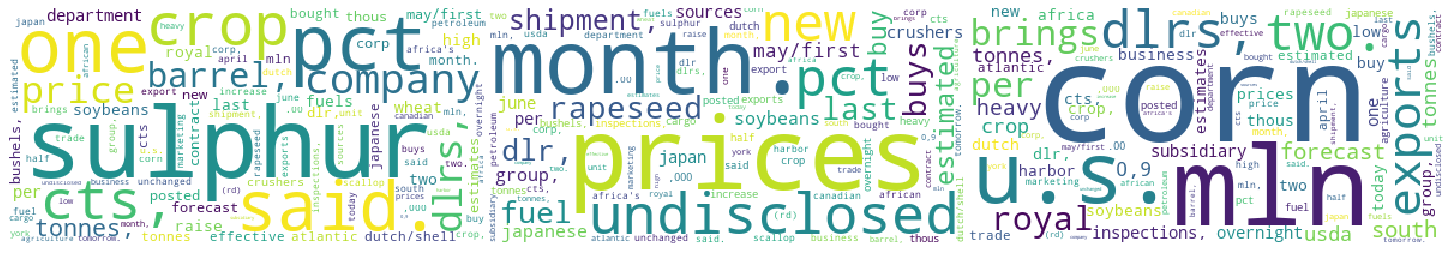

In [31]:
NO_SAMPLES=MASTER_MCMC_SAMPLE

# Build the model
lda_model = LDA(CORPUS).build()
# Sample the model
lda_sampler = LDASampler(lda_model).sample(NO_SAMPLES, False)

# Return results
analizer = LDAAnalizer(lda_sampler) \
    .print_document_topic_distribution() \
    .print_document_word_topic_assignement() \
    .show_wordcloud_topic_word_distribution()
#    .print_topic_word_distribution()

#### Document topic distribution
Plot the topic distribution histograms for each document.

Each topic distribution is ploted using an alpha transparency value. The common part of the topic distributions will have a more intense color.

Notice that if a document has common words in different topics those topic distribution will be closer for that document (check the correlation matrix for common words)

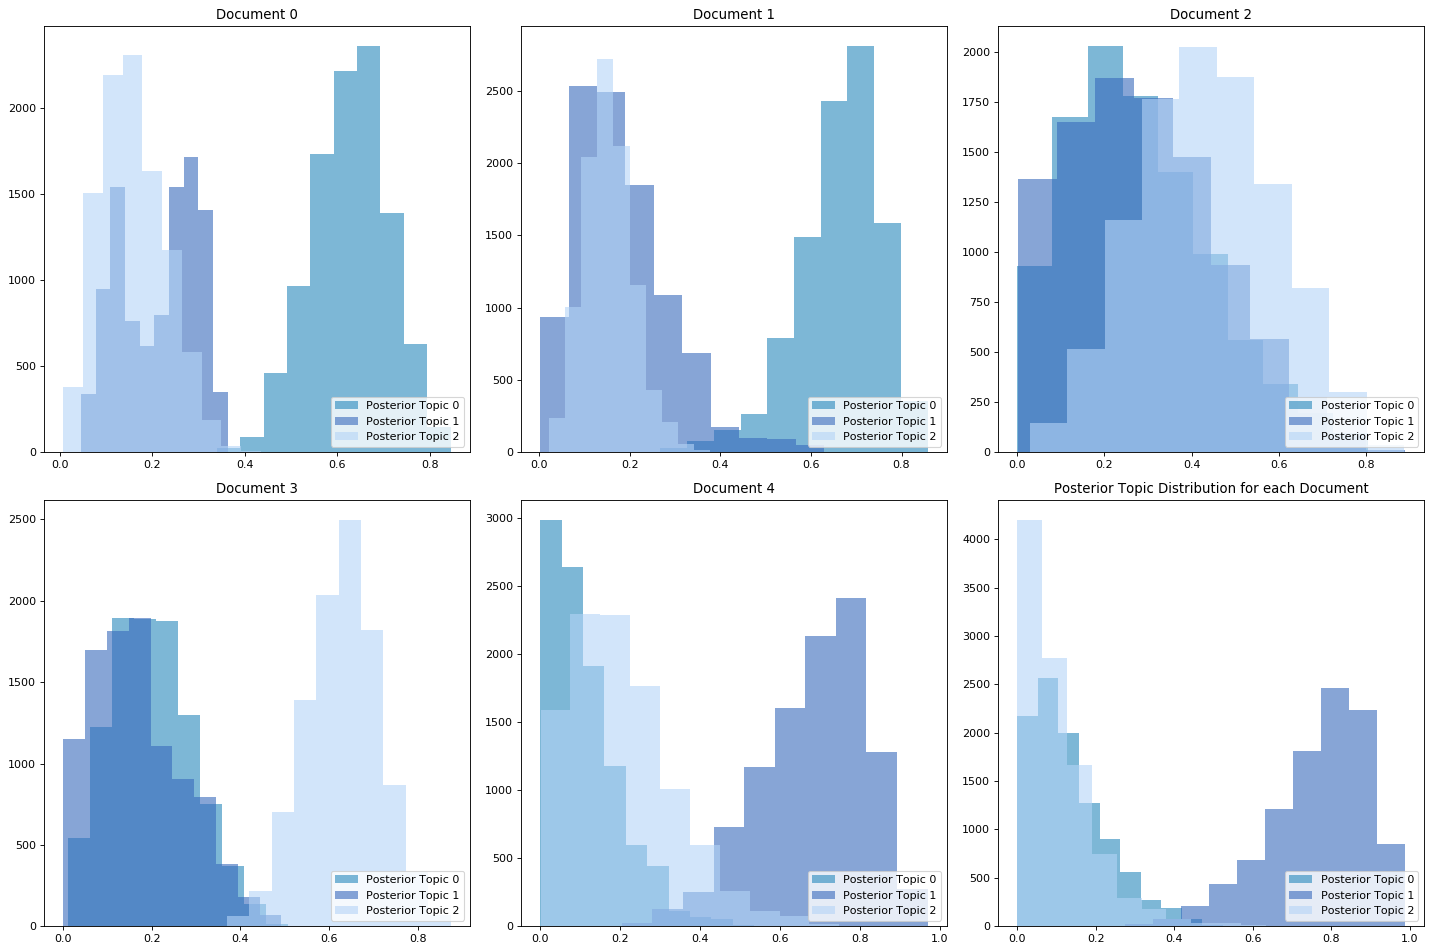

In [32]:
analizer = analizer.plot_document_topic_distribution()

#### Check MCMC Convergence
Model and convergence check is part of the art of any Bayesian sampler method.

* Informal methods include plotting the traces of a stochastic latent variable and check if it exhibits asymptotic behaviour, meaning the mean and variance of the trace chain becomes constant

* Autocorrelation of trace chain: A chain that is exploring the space well will exhibit very high autocorrelation. Visually, if the trace seems to meander like a river, and not settle down, the chain will have high autocorrelation. This does not imply that a converged MCMC has low autocorrelation. Hence low autocorrelation is not necessary for convergence, but it is sufficient. *Probabilistic Programming and Bayesins Methods for Hacking*
* Geweke analysis is a time-series approach that compares the mean and variance of segments from the beginning and end of a single chain.f the z-scores (theoretically distributed as standard normal variates) of these two segments are similar, it can provide evidence for convergence. PyMC calculates z-scores of the difference between various initial segments along the chain, and the last 50% of the remaining chain. If the chain has converged, the majority of points should fall within 2 standard deviations of zero (-2, 2). https://pymc-devs.github.io/pymc/modelchecking.html
* Raftery procedure This approach estimates the number of iterations required to reach convergence, along with the number of burn-in samples to be discarded and the appropriate thinning interval.

**Run convergence analysis for each document's topic distribution. Increase the number of samples if you observe non convergence**


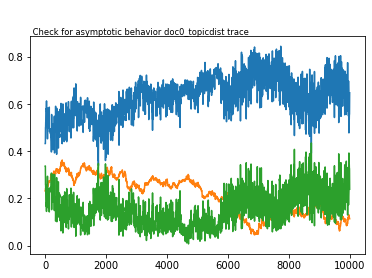

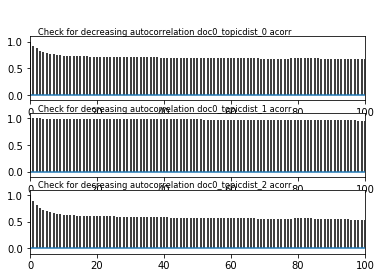

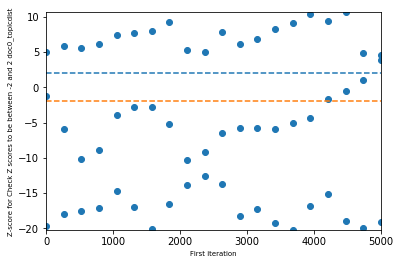

In [33]:
class SamplerAnalitics(object):
    def __init__(self, sampler : LDASampler):
        self._sampler = sampler

    @property
    def sampler(self):
        return self._sampler

    def plot_traces(self, latent_var):
        samples = np.squeeze(self._sampler.mcmc.trace(latent_var)[:])
        pm.Matplot.trace(samples, 'Check for asymptotic behavior {}'.format(latent_var), verbose=0)
    
    def plot_autocorrelation(self, latent_var):
        samples = np.squeeze(self._sampler.mcmc.trace(latent_var)[:])
        pm.Matplot.autocorrelation(samples, 'Check for decreasing autocorrelation {}'.format(latent_var), verbose=0)

    def plot_geweke(self, latent_var):
        samples = np.squeeze(self._sampler.mcmc.trace(latent_var)[:])
        try:
            # For low sample number in cannot inverse some matrix - perhaps too corellated samples
            scores = pm.geweke(samples, first=0.1, last=0.5, intervals=20)
            pm.Matplot.geweke_plot(scores, 'Check Z scores to be between -2 and 2 {}'.format(latent_var))
        except:
            pass

    def plot_raftery_lewis(self, q=0.025, r=0.01):
        """q=0.025 (the lower limit of the equal-tailed 95% interval) and error r=0.01"""
        pm.raftery_lewis(self._sampler.mcmc, q, r)

    def plot_document_topicdist_stats(self, doc_id):
        self.plot_traces(self._sampler.model.var_name('docs_topicdist', doc_id))
        self.plot_autocorrelation(self._sampler.model.var_name('docs_topicdist', doc_id))
        self.plot_geweke(self._sampler.model.var_name('docs_topicdist', doc_id))

# plot statistics only for the topic distribution in the first document
SamplerAnalitics(lda_sampler).plot_document_topicdist_stats(0)
# takes to much time. Should be done at first
#analitics.plot_raftery_lewis()

#### Hyperparameters impact
In standard LDA there are 2 common hyperparameters alpha and beta that control the Dirichlet distribution for topic distribution in each document and the word distribution in each topic.

Below is a sample plot of the Dirichlet distribution for 5 values of theta, each having 3 components for each sample of the Dirichlet distribution (http://blog.bogatron.net/blog/2014/02/02/visualizing-dirichlet-distributions/) with their probability sum up to 1. Each of these 3 component probability coresponds to a point on the triangle axes, the resulting point in the middle of the triangle being plotted (barycentric coordonate system).

To understand the Dirichlet barycentric triangle plot there are 2 different values of theta that come into play:
1. The **relative size of theta between each other**:
    1. For example if theta0 < theta1 < theta2 this means that the last component will have a overall much higher sampled probability than the first component.
    2. For theta1=theta2=theta3 the probability distribution seems to be simetrical around the triangle center of the 2-simplex. This coresponds to a prior knowledge that the 3 components of the Dirirchlet distribution are not correlated and that the probability samples will take an uniform value (not necessary equal)
2. The **absolute value of thetas** (their size). This encodes the current degree of confidence in the above relative values of theta
    1. For a symetric small value of theta value under 1 (0.1) the distribuiton is scattered near the triangle axes. This translates to the fact that we have a low confidence about the fact that the 3 components have equal probability (all 3 components relative value is the same - 0.1) since the middle of the triangle (where 0.3/0.3/0.3 would be) is empty.
    2. For a value of theta of 1 notice that the probability distribution is pretty smooth all around. This translates to a lack of knowledge about the underlying distribution since we want to sample every possible location of the simplex.
    3. For large value of theta we high a high confidence of the relative distribution of the components. E.g. theta1 < theta2 with large absolute values would mean we are confident that the last component should have a higher sampled probability that the other one. Notice on the graph how the probability space becomes more clustered (not necessary simmetric)
    
Now to get back to LDA and analize the alpha values for the topic distribution in each document. They will encode our prior knowledge of the topic distribution given our prevously seen data.
* if we have no ideea about of document structure we should set alpha values for that document near 1. This way we sample every possible combination of topic distribution.
* if we have seen a lot of data and notice that topic 2 for example has a higher distibution, that we should set alpha2 a higher value than all other alphas (alpha2 > alphax) **and** use a higher absolute value for alpha2 to encode confidence.
To keep it simple set alphas to the known relative distribution of seen topics (how many topic1, topic2 and so on) and set the absolute values (confidence levels) proportional to the amount of data seen. E.g. if we seen 10k documents we should set alphax near 100.

The same should be done for beta, for the word distribution in each topic.

Wrote plots to "dirichlet_plots.png".
 [-----------------100%-----------------] 1500 of 1500 complete in 9.2 sec



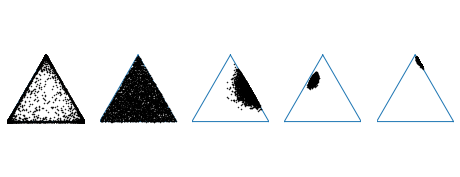

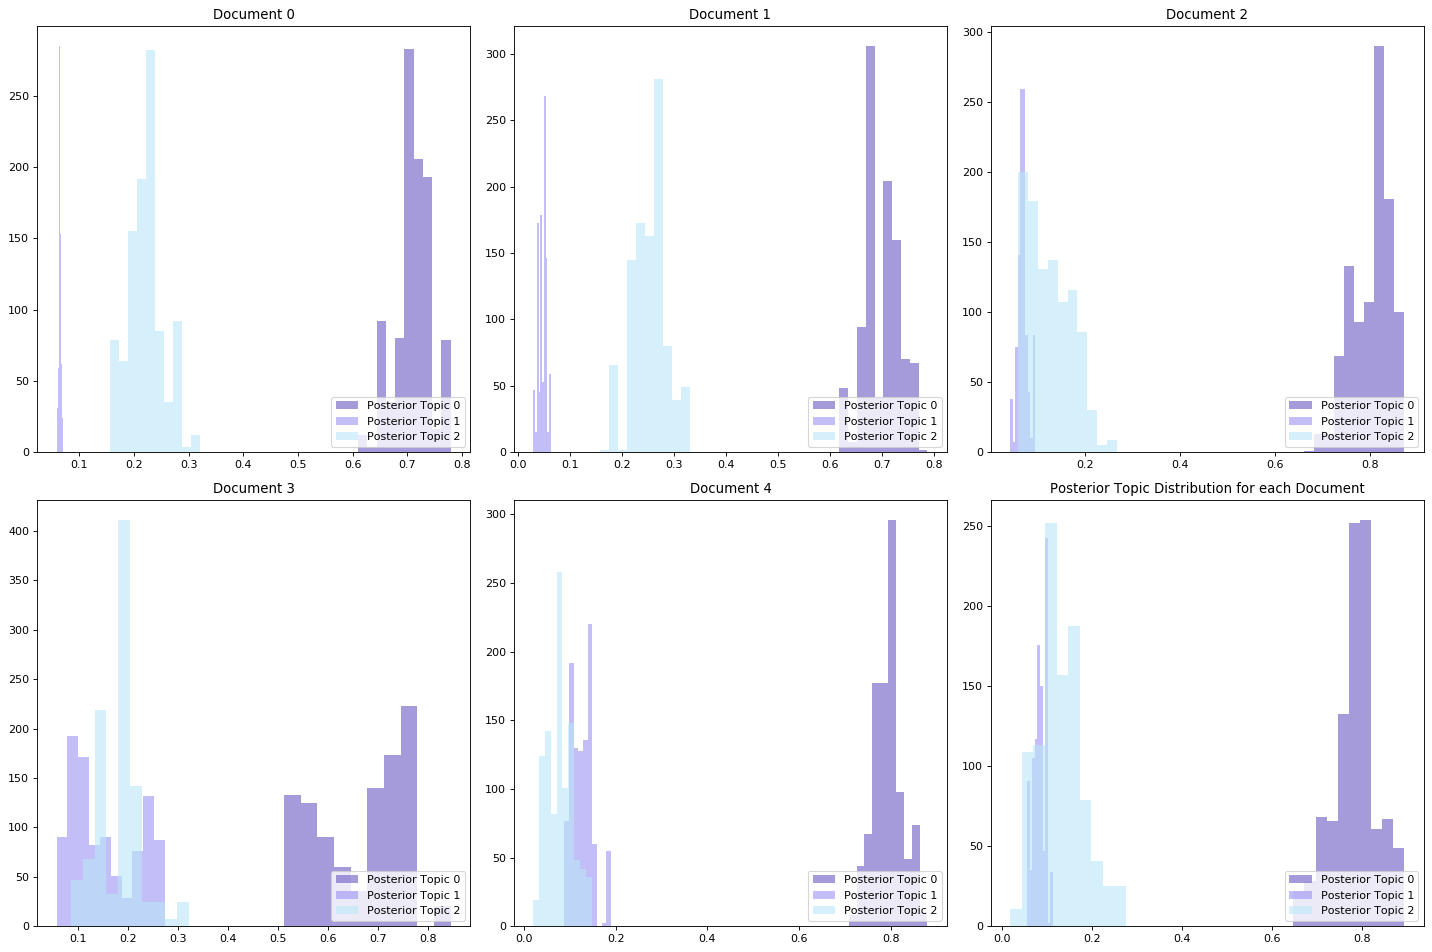

In [34]:
# Dirichlet plot taken from https://gist.github.com/tboggs/8778945
#%load "./simplex_plots.py"
%run "./simplex_plots.py"
plot_dirichlet([[0.1, 0.1, 0.1], [1, 1, 1], [1, 10, 10], [50, 10, 100], [0.1, 10, 100]])

# take the first topic and assign it a higer alpha value. Notice how the topic distribution is now computed
alpha = np.full((CORPUS.no_topics), 1)
alpha[0] = 50
_ = LDAAnalizer(LDASampler(LDA(CORPUS, alpha=alpha).build()).sample(1000, False)).plot_document_topic_distribution()

### Topic similarity measure between documents
The posterior topic distribution of each document can be used to define a document similarity measure using only the topic distribution. This way we reduce the representation of the documents from a the V-1 simplex to the K-1 simplex where V is the number of words in the vocabulary and K is the number of topics.

Several ways can be used to define a similarity measure:
1. Use only the expectation (mean) of the topic distribution for each document and define the cosine similarity (measured in radians)
    $similarity_{i,j} = cos(\theta) = \frac {E(Doc_i topics) * E(Doc_j topics)} {\lVert E(Doc_i topics) \lVert \lVert E(Doc_j topics)\lVert} $

    A cosine similarity of 1 means the documents are identical

2. Use the Hellinger distance between documents as defined on http://www.cs.columbia.edu/~blei/papers/BleiLafferty2009.pdf also on the expectation (mean) of the topic distribution for each document

    $similarity_{i,j} = \sum_{k=1}^K ( \sqrt{E(Doc_i topics_k)} - \sqrt{E(Doc_j topics_k)} )^2$
    
    A Hellinger similarity of 0 means the documents are identical
   
3. Use the entire topic probability distribution for each document. In order to compare 2 probability distributions the Kullback-Leibler Divergence (KL divergence) is usually used as a measure (used in Variational Inference as well). The problem with KL divergence is that is not simetric nor it respects the triangle inequality. To overcome this we define the following metric between 2 documents, where for documents i,j we measure KL for each topic k between i, j and j, i simetrically:

    $similarity_{i,j} = \frac{1}{2} * \sum_{k=1}^K (KL(Doc_i topic_k \lVert Doc_j topic_k) + KL(Doc_j topic_k\lVert Doc_i topic_k))$
    
    $KL(A\lVert B) = \sum P(A) * \log (\frac{P(A)}{P(B)})$

Will  return the average similarity for all topics. The problem we have to consider is that the topic distributions for our documents its not a simple distribution but rather samples that came from that distribution. Also KL is not defined when P(B) is 0 but we consider it 0.

In [35]:
class LDADocMetrics(object):
    def __init__(self, sampler : LDASampler):
        self._sampler = sampler
    
    @staticmethod
    def cosine(ed1, ed2):
        return np.dot(ed1, ed2) / (np.linalg.norm(ed1) * np.linalg.norm(ed2)) 
    
    @staticmethod
    def hellinger(ed1, ed2):
        return np.sum(np.power((np.sqrt(ed1) - np.sqrt(ed2)), 2))

    @staticmethod
    def KL(sd1, sd2):
        def kl1(a, b):
            return np.sum(np.where(a != 0, a * np.log(a / b), 0))

        s = 0
        K = sd1.shape[-1]
        # return the average of the KL between each topic
        for k in range(K):
             s += (kl1(sd1[k], sd2[k]) + kl1(sd1[k], sd2[k])) / 2
        return s / K
    
    def compute_doc_similarities(self):
        samples_topics, mean_topic, _ = self._sampler.docs_topic_distribution
        no_docs = len(mean_topic)
        for d1 in range(no_docs):
            for d2 in range(d1+1, no_docs):
                print('Document {} <=?=> Document {} \t Cosine: {:.5f} \t Hellinger: {:.5f} \t KL: {:.5f}'.format(
                    d1, d2, LDADocMetrics.cosine(mean_topic[d1], mean_topic[d2]),
                    LDADocMetrics.hellinger(mean_topic[d1], mean_topic[d2]),
                    LDADocMetrics.KL(samples_topics[d1], samples_topics[d2])))

LDADocMetrics(lda_sampler).compute_doc_similarities()

Document 0 <=?=> Document 1 	 Cosine: 0.99821 	 Hellinger: 0.00175 	 KL: 0.21572
Document 0 <=?=> Document 2 	 Cosine: 0.75870 	 Hellinger: 0.14286 	 KL: 0.10972
Document 0 <=?=> Document 3 	 Cosine: 0.56295 	 Hellinger: 0.27771 	 KL: 0.54408
Document 0 <=?=> Document 4 	 Cosine: 0.50591 	 Hellinger: 0.34447 	 KL: 0.66675
Document 0 <=?=> Document 5 	 Cosine: 0.49122 	 Hellinger: 0.36153 	 KL: 0.39601
Document 1 <=?=> Document 2 	 Cosine: 0.73103 	 Hellinger: 0.16475 	 KL: 0.45597
Document 1 <=?=> Document 3 	 Cosine: 0.54177 	 Hellinger: 0.29631 	 KL: 1.37377
Document 1 <=?=> Document 4 	 Cosine: 0.45346 	 Hellinger: 0.39264 	 KL: 0.69313
Document 1 <=?=> Document 5 	 Cosine: 0.43960 	 Hellinger: 0.41019 	 KL: 0.33363
Document 2 <=?=> Document 3 	 Cosine: 0.93803 	 Hellinger: 0.04004 	 KL: 0.43358
Document 2 <=?=> Document 4 	 Cosine: 0.74074 	 Hellinger: 0.16541 	 KL: 1.23011
Document 2 <=?=> Document 5 	 Cosine: 0.64973 	 Hellinger: 0.25863 	 KL: 0.81613
Document 3 <=?=> Document 4 

### LDA prediction
LDA model is a generative model not a discrimative one.

A discrimative model can create a separation boundary between the classes invoved that can be used to clasiffy additional data.

A generative model can be used to generate new data based on previous learned weights.

In our LDA case the learned weights are the word distribution in each topic, TW. The vocabulary, number of topics are considered to be fixed at this point. This can be used to generate new documents as follows:
1. Assume that you want a document that has a specific topic distribution T over the fixed topics (60% science, 40% art)
2. Randomly select the number of words N in the new document
3. For each N word to be generated:
    1. Draw the current word topic t from T
    2. Draw the generated word from TW[t] distribution
    
In the case of doing prediction on a new documents we consider the learned distribution fixed. The only distribution that we actually need is the word distribution in each topic. The 3 other types of distribution are no longer needed as they relate to the training of the mode on the avaible observed data (training documents).

The prediction process is then:
1. Filter the document on the fixed vocabulary (all new words are ignored)
2. Create a new LDA process where:
    1. The word distribution in each topic is the trained model distribution
    2. Create a single Dirichlet topic distribution only for the new document
    3. For each word in the new document create a Categorical topic distribution
    4. Create the observed Categorical distribution of words only for the new document.
3. Sample the new LDA process using MCMC. Since the process now contains fewer latent variables it will run much faster. The same convergence tests should be applied (e.g. number of samples is not necessary fewer then done for the trained model).
---
##### Implementation notes
* Step A is implemented by adding the Dirichlet container for that distribution from the old trained model and adding it to the new prediction model only as a Deterministic variable. **Since the CompletedDirichlet is a deterministic variable and since we no longer add their parent normal Dirichlet stochastic distribution to the sampler their values will only be drawn once in the MCMC process according to the currently fitted expected values.**
* Steps B,C,D are done by created new stochastic variables according the LDA specification **only** for the new document

In [36]:
class LDAPredict(LDA):
    def __init__(self, corpus : CorpusTokenizer, model : LDA):
        # Each new predicted latent variable in the MCMC database will have a suffix of '_p'
        super(LDAPredict, self).__init__(corpus, suffix='_p')
        self._parent_model = model
    
    def var_name(self, var_type, *args):
        """ Override this method to get the proper nae for the old topics_worddist variables
        """
        if var_type == 'topics_worddist':
            return "topic{}_worddist".format(args[0])
        else:
            return super(LDAPredict, self).var_name(var_type, *args)
    
    def build(self):
        new_doc_id = 0

        #for var in self._parent_model._latent['topics_worddist']:
        #    var.verbose=1

        # The word distribution of topics does remain the same taken from the parent model shape=[NO_TOPICS x VOCABULARY_SIZE]
        self._latent['topics_worddist'] = self._parent_model._latent['topics_worddist']
        
        # Create the model's topic distribution only for the new model shape=[1 x NO_TOPICS]
        # Use the same hyperparameter as the original document
        self._latent['docs_topicdist'] = [self._dirichlet(self.var_name("docs_topicdist", new_doc_id), self._hyper['alpha'])]
        
        # For each word in the new document create its topic distribution [1 x DOC_LENGTH(new_doc)]
        self._latent['docwords_topicdist'] = [self._build_wordpos_topicdist(new_doc_id)]

        # Add the new observed data only for the new document shape=[1 x DOC_LENGTH(new_doc)]
        self._latent['observed_doc_words'] = [self._observed_doc_word(new_doc_id, word_pos)
                                              for word_pos in range(len(self.corpus.documents[new_doc_id]))]

        return self

#### Predict a new document
1. Select a random topic from the current topic list.
2. Select a random document from the data set that contains the above topic
3. Tokenize it using the previous vocabulary in the old model
3. Construct the LDA prediction model and test it

 [-----------------100%-----------------] 15000 of 15000 complete in 12.9 sec

========================Predicted topic assignment in trained data========================
Topic 1 is assigned to documents with true topics: ["['oilseed' 'rapeseed']", "['oilseed' 'rapeseed']"]

================================Predicted model assignement===============================
LDA assigned topic vs True topics in documents:
Topic 1 -> ['oilseed' 'rapeseed']

Expected topic distribution
[[0.108529 0.755642 0.135829]]


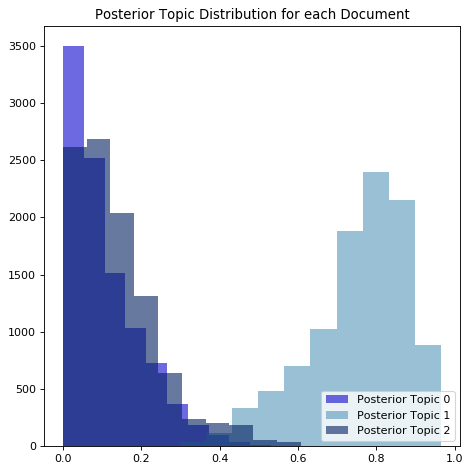

In [37]:
NO_SAMPLES_PRED=MASTER_MCMC_SAMPLE
# Get a random topic from the current trained topic list and select one document
# Use the previous vocabulary to tokenize the document
# Make sure you don't choose duplicates
while True:
    prediction_corpus =  CorpusTokenizer(pDF, [random.choice(list(CORPUS.topics.keys()))],
                                         1).sample_documents(min_doc_topics=0).tokenize(vocabulary=CORPUS.vocabulary)

    if SANITY or not np.any([np.array_equal(prediction_corpus.documents, doc) for doc in CORPUS.documents]):
        break

prediction_corpus._topics = CORPUS.topics
prediction_corpus._no_topics = CORPUS.no_topics

predict_analizer = LDAAnalizer(LDASampler(LDAPredict(prediction_corpus, lda_model).build()).sample(NO_SAMPLES_PRED))

print('========================Predicted topic assignment in trained data========================')
_, _, predicted_topic = predict_analizer.sampler.docs_topic_distribution
analizer.print_documents_with_best_topic(predicted_topic[0])
print('================================Predicted model assignement===============================')
_ = predict_analizer.print_document_topic_distribution(print_best_topic_words=False).plot_document_topic_distribution()

### Correlated topic model
CTP addresses certain limitation of LDA model, namely the assumed topic independance. What CTP wants to model is the possible correlation between the presence of a topic and other topics, namely that similar topics should have more correlated probabilities to be assigned to a specific document.

The only thing that is changed in the CTP is how the documents topic distribution is computed. Previously it used a Dirichlet distribution with the alpha hyperparameter. Now the logistic normal distribution is used, by drawing each document's topic distribution from a multivariate gaussian distribution with mean $\mu$ and covariance $\sum$ which is mapped to the simplex of the words in each document (normalized the same as Dirichlet to sum up to 1) using a softmax function. K topic probabilities are sampled at once from the multivariate gaussian, then normalized to sum up to 1:

$\eta_d \leftarrow N(\mu,\sum)$ and $topicdistindocument = softmax(\eta_d) = \frac{\eta}{\sum_{ti} \eta_{ti}}$

As describe in https://arxiv.org/pdf/0708.3601.pdf the problem with CTP model is that the posterior probability converges slowly using default MCMC methods. The paper talks that since logistic normal is not conjugate to the multinomial as before the prior tricks that were previously used to analitically compute the integral of the denominator, the marginal probability of the document, are no longer possible.

---
**Implementation notes**

* CTP extends and modifies LDA class by replacing the document topic distribution with a softmax normalized MvNormal
* The alpha hyperparameter is removed and replaced by the multivariate's mean and covariance
* The MvNormal pymc class is also created in-place by the python framework. We need to add the precision matrix (the inverse of the covariance matrix) as in pymc.Normal distribution.
* The MvNormal pymc distribution expects a positive definite precision matrix. In order to make the covariance matrix inversable and the resulted precision matrix positive definite apply the small regularization trick (add a diagonal identity matrix until it is positive definite)
* Add the above stochastic variable to our MCMC sampler


In [38]:
class CTP(LDA):
    def __init__(self, corpus : CorpusTokenizer, topic_mean=None, topic_cov=None, beta=1., suffix='_ctp', verbose=0):
        super(CTP, self).__init__(corpus, beta=beta, suffix=suffix, verbose=verbose)

        # assume independence if nothing is given
        if topic_mean is None:
            topic_mean = np.zeros((corpus.no_topics,))
        if topic_cov is None:
            topic_cov = np.identity(corpus.no_topics)
        self._hyper['topic_mean'] = topic_mean
        self._hyper['topic_cov'] = topic_cov

    @staticmethod
    def softmax(x):
        softmax = np.exp(x) / np.sum(np.exp(x))
        #assert abs(1 - np.sum(softmax)) < 0.0001
        return softmax

    @staticmethod
    def make_positive_definite(x):
        if not np.all(np.linalg.eigvals(x) > 0):
            x += 0.1 * np.identity(len(x))
        return x

    def build(self):
        topic_ids = range(self.corpus.no_topics)
        doc_ids = range(self.corpus.no_documents)
        
        # Container of each topic and their word distribution shape=[NO_TOPICS x VOCABULARY_SIZE]
        self._latent['topics_worddist'] = [self._dirichlet(self.var_name('topics_worddist', topic_id), self._hyper['beta'])
                                           for topic_id in topic_ids]

        # compute the precision matrix as required by PYMC2
        # make sure the covariance matrix is pozitive definite so it is inversable (it is simetric)
        # make sure the resulted precision matrix is also pozitive definite
        covariance = CTP.make_positive_definite(self._hyper['topic_cov'])
        precision_matrix = np.linalg.inv(covariance)
        precision_matrix = CTP.make_positive_definite(precision_matrix)

        # Get the topic distribution from the multivariate normal
        mv_doc_topicdist = [pm.MvNormal('topics_mv_normal{}{}'.format(doc_id, self.suffix),
                                        mu=self._hyper['topic_mean'], tau=precision_matrix, verbose=self._verbose)
                            for doc_id in doc_ids]
        # Make sure this gets added to the sampler
        self._latent['additional_stochastic'] += mv_doc_topicdist

        # Container of each document and their topic distribution shape=[NO_DOCS x NO_TOPICS]
        # For CTP this is taken as the softmax normalized distribution sampled from a multivariate gaussian
        self._latent['docs_topicdist'] = [pm.Lambda(self.var_name('docs_topicdist', doc_id),
                                                    lambda topic_dist=mv_doc_topicdist[doc_id] : CTP.softmax(topic_dist),
                                                    verbose=self._verbose)
                                          for doc_id in doc_ids]

        # For each word in a document get their topic distribution shape=[NO_DOCS x DOC_LENGTH(docid)]
        self._latent['docwords_topicdist'] = [self._build_wordpos_topicdist(doc_id) for doc_id in doc_ids]

        # For each document get the true(observed) word distribution as the product of the distribution of
        # of the specific word to a topic and of that topic to words shape=[NO_DOCS x DOC_LENGTH(docid)]
        self._latent['observed_doc_words'] = [self._observed_doc_word(doc_id, word_pos)
                                              for doc_id in doc_ids # for all docs
                                              # for all word position in the doc
                                              for word_pos in range(len(self.corpus.documents[doc_id]))]

        return self

#### Check correlated topic impact
1. Select a number of documents that have at least 2 topics from our choice
2. Run a normal LDA on them to get some reference parameters
3. Run the CTP model with no correlation (identity covariance matrix). Observe the difference from LDA as in this case the topics are also assumed to be independent
4. Run the CTP model with the first 2 topics correlated and the last one anticorrelated. Check if the model behaves better than the LDA.


Normally the CTP should offer a better fit than the LDA and support more topics. Since the prior model of the per document topic distribution will start with a higher probability values for correlated topics, the **posterior expection of correlated topics in a document should be higher than in the LDA model**.

In [44]:
CTP_NO_SAMPLES=MASTER_MCMC_SAMPLE
# only choose 3 topics from the data set
CTP_TOPICS =  ['grain', 'rice', 'fuel']
# each document has to have at least 2 common topics
MIN_COMMON_TOPICS = 1
# Here sampled variable 1 and 2 increase and 3 decrease (correlation and anticorrelation)
topic_cov = np.cov(np.array([[0, 1, 2],[2, 6, 7],[2, 1, 0.5]]))

if SANITY:
    CTP_TOPICS =  ['topic0', 'topic1']
    MIN_COMMON_TOPICS = 0
    topic_cov = np.cov(np.array([[0, 1, 2], [2, 6, 7]]))

# Select topics from the document set. Make sure that they each contain at least 2 of the above topics
ctp_corpus = CorpusTokenizer(pDF, CTP_TOPICS, NO_DOCUMENTS).sample_documents(min_doc_topics=MIN_COMMON_TOPICS).tokenize()
print(ctp_corpus)

# Check the reuslts for the standard LDA
print('============================STANDARD LDA============================')
ctp_lda_a = LDAAnalizer( LDASampler(LDA(ctp_corpus).build()).sample(CTP_NO_SAMPLES) ).print_document_topic_distribution()

# Check the results for the CTP 
print('========================CTP - NO CORRELATION========================')
ctp_ind_a = LDAAnalizer( LDASampler(CTP(ctp_corpus).build()).sample(CTP_NO_SAMPLES) ).print_document_topic_distribution()

# Set the first 2 topics to correlate and the 3rd to anticorrelated
print('=================CTP - CORRELATION between {}-{} ============='.format(*CTP_TOPICS[:2]))
print('Covariance matrix {}-{} correlate, {} anticorrelate:\n{}'.format(*CTP_TOPICS[:2], CTP_TOPICS[2:], topic_cov))
ctp_cov_a = LDAAnalizer( LDASampler(CTP(ctp_corpus, topic_cov=topic_cov).build()).sample(CTP_NO_SAMPLES) ).print_document_topic_distribution()

Number of documents: 6
True topic list for each document(a doc may contain more than 1 topics):
['corn' 'grain' 'wheat']
['corn' 'grain' 'sugar']
['grain']
['crude' 'fuel' 'nat-gas']
['grain' 'rice']
['grain' 'wheat']
Chosen topics: ['grain', 'rice', 'fuel']
============================STANDARD LDA============================
 [-----------------100%-----------------] 15000 of 15000 complete in 563.7 sec

LDA assigned topic vs True topics in documents:
Topic 0 -> ['corn' 'grain' 'wheat']
Topic 0 -> ['corn' 'grain' 'sugar']
Topic 1 -> ['grain']
Topic 1 -> ['crude' 'fuel' 'nat-gas']
Topic 2 -> ['grain' 'rice']
Topic 0 -> ['grain' 'wheat']

LDA assigned best words in topics:
Topic 0 -> ['approve' 'burnham' 'corn']
Topic 1 -> ['market' 'led' 'prices']
Topic 2 -> ['release' 'likely' "vietnam's"]

Expected topic distribution
[[0.474761 0.212351 0.312888]
 [0.434727 0.197128 0.368145]
 [0.138903 0.584312 0.276785]
 [0.276063 0.370485 0.353452]
 [0.295094 0.209005 0.4959  ]
 [0.457408 0.321922 

In [45]:
print('\n\n==========================RESULTS Best Topic and Expected probability==========================')
row_format ="{:>7}     " * 7
print(row_format.format('Documents', 'LDA', '',
                            'CTP-independance', '',
                            'CTP-covariance', ''))
_, mean_topic1, best_topic1 = ctp_lda_a.sampler.docs_topic_distribution
_, mean_topic2, best_topic2 = ctp_ind_a.sampler.docs_topic_distribution
_, mean_topic3, best_topic3 = ctp_cov_a.sampler.docs_topic_distribution
best_topic1 = ctp_lda_a.sampler.topic_names(best_topic1)
best_topic2 = ctp_ind_a.sampler.topic_names(best_topic2)
best_topic3 = ctp_cov_a.sampler.topic_names(best_topic3)
for i in range(ctp_corpus.no_documents):
    print(row_format.format('Document {}'.format(i), best_topic1[i], round(np.max(mean_topic1[i]), 5),
                            best_topic2[i], round(np.max(mean_topic2[i]), 5),
                            best_topic3[i], round(np.max(mean_topic3[i]), 5)))



==========================RESULTS Best Topic and Expected probability==========================
Documents         LDA                 CTP-independance                 CTP-covariance                 
Document 0     Topic 0     0.47476     Topic 1     0.36207     Topic 0     0.37883     
Document 1     Topic 0     0.43473     Topic 2     0.50506     Topic 1     0.35062     
Document 2     Topic 1     0.58431     Topic 1     0.45968     Topic 0     0.47951     
Document 3     Topic 1     0.37048     Topic 2     0.41845     Topic 1     0.40646     
Document 4     Topic 2      0.4959     Topic 1     0.38785     Topic 2     0.52026     
Document 5     Topic 0     0.45741     Topic 1     0.38796     Topic 0     0.47929     


### Dynamic topic model
Dynamic topic model tries to model the evolution of topics over time. The assumption is that a set of documents are grouped in time slices and the documents of each group come from a set of topics that evolved from the set of the previous slice.

This way you can monitor the evolution of some words in topics in different time slices.

Similar with the Correlated topic model now **both** Dirichlet distributions of topic in documents and word vocabulary in topics are replaced with the logistic normal distribution (multivariate gaussian normalized by softmax to sum up to 1). The only difference is that now the **means** of the multivariate gaussian distribution are taken as stochastic variables from the previous corresponding logistic normal distribution.

$\eta_{d,t} \leftarrow N( topicdistindocument_{t-1},\sum)$ and $topicdistindocument_t = softmax(\eta_{d,t}) = \frac{\eta_t}{\sum_{ti} \eta_{ti,t}}$

$\beta_{k,t} \leftarrow N( topicvocabularydist_{t-1},\sum)$ and $topicvocabularydist_t = softmax(\beta_{k,t}) = \frac{\beta_t}{\sum_{vi} \beta_{vi,t}}$

This normalized variables are plugged-in into the other 2 types of latent distribution as before.

For each time slice t we have a different LDA model with all of the above variables. **Sample all models together on the same corpus of documents**

---
**Implementation notes:**
* Each DYNt class will contain the alpha_dist and beta_dist multivariate normal distributions that will plugged in by the DYN class as alpha and beta hyperparameters of DYNt+1.
* The alpha and beta coveriance matrix for all DYNt was kept the same (identity - independence).
* For a single time slice/epoch DYNt class that extended LDA was constructed. All T epochs were implemented by chaining T DYNt classes together. This is done by the DYN class, that also picks up all the latent variables from all the DYNt classes and adds them to MCMC.
* All stochastic variables for all time slices were added to MCMC sampler
* The same documents were added to all the epochs
* The same problem with the positive semidefinite precision matrix for the multivariate normal distribution had to be fixed

In [41]:
class DYNt(LDA):
    def __init__(self, corpus : CorpusTokenizer,
                 alpha_mean, beta_mean, alpha_cov, beta_cov, suffix= '_dyn0', verbose=0):
        # assume independence if nothing is given
        if alpha_mean is None:
            alpha_mean = [np.zeros((corpus.no_topics,)) for _ in range(corpus.no_documents)]
        if beta_mean is None:
            beta_mean = [np.zeros((corpus.no_vocabulary,)) for _ in range(corpus.no_topics)]
        if alpha_cov is None:
            alpha_cov = np.identity(corpus.no_topics)
        if beta_cov is None:
            beta_cov = np.identity(corpus.no_vocabulary)

        super(DYNt, self).__init__(corpus, alpha=alpha_mean, beta=beta_mean, suffix=suffix, verbose=verbose)
        self._hyper['alpha_cov'] = alpha_cov
        self._hyper['beta_cov'] = beta_cov

    @staticmethod
    def softmax(x):
        softmax = np.exp(x) / np.sum(np.exp(x))
        assert abs(1 - np.sum(softmax)) < 0.0001
        return softmax
    
    @staticmethod
    def make_positive_definite(x):
        if not np.all(np.linalg.eigvals(x) > 0):
            x += 0.1 * np.identity(len(x))
        return x

    @staticmethod
    def make_precision(cov):
        # compute the precision matrix as required by PYMC2
        # make sure the covariance matrix is pozitive definite so it is inversable (it is simetric)
        # make sure the resulted precision matrix is also pozitive definite
        covariance = DYNt.make_positive_definite(cov)
        precision_matrix = np.linalg.inv(covariance)
        precision_matrix = DYNt.make_positive_definite(precision_matrix)
        return precision_matrix

    def build(self):
        topic_ids = range(self.corpus.no_topics)
        doc_ids = range(self.corpus.no_documents)

        # compute the precision matrix as required by PYMC2 
        precision_matrix = DYNt.make_precision(self._hyper['beta_cov'])
        # Get the word distribution in each topic from the multivariate normal
        mv_topics_worddist = [pm.MvNormal('word_topics_mv_normal{}{}'.format(topic_id, self.suffix),
                                          mu=self._hyper['beta'][topic_id], tau=precision_matrix, verbose=self._verbose)
                              for topic_id in topic_ids]
        self._latent['beta_dist'] = mv_topics_worddist
        # Container of each topic and their word distribution shape=[NO_TOPICS x VOCABULARY_SIZE]
        self._latent['topics_worddist'] = [pm.Lambda(self.var_name('topics_worddist', topic_id),
                                                    lambda word_dist=mv_topics_worddist[topic_id] : DYN.softmax(word_dist),
                                                    verbose=self._verbose)
                                           for topic_id in topic_ids]

        # compute the precision matrix as required by PYMC2 
        precision_matrix = DYNt.make_precision(self._hyper['alpha_cov'])
        # Get the topic distribution from the multivariate normal
        mv_doc_topicdist = [pm.MvNormal('topics_mv_normal{}{}'.format(doc_id, self.suffix),
                                        mu=self._hyper['alpha'][doc_id], tau=precision_matrix, verbose=self._verbose)
                            for doc_id in doc_ids]
        self._latent['alpha_dist'] = mv_doc_topicdist
        # Container of each document and their topic distribution shape=[NO_DOCS x NO_TOPICS]
        # For CTP this is taken as the softmax normalized distribution sampled from a multivariate gaussian
        self._latent['docs_topicdist'] = [pm.Lambda(self.var_name('docs_topicdist', doc_id),
                                                    lambda topic_dist=mv_doc_topicdist[doc_id] : DYN.softmax(topic_dist),
                                                    verbose=self._verbose)
                                          for doc_id in doc_ids]

        # For each word in a document get their topic distribution shape=[NO_DOCS x DOC_LENGTH(docid)]
        self._latent['docwords_topicdist'] = [self._build_wordpos_topicdist(doc_id) for doc_id in doc_ids]

        # For each document get the true(observed) word distribution as the product of the distribution of
        # of the specific word to a topic and of that topic to words shape=[NO_DOCS x DOC_LENGTH(docid)]
        self._latent['observed_doc_words'] = [self._observed_doc_word(doc_id, word_pos)
                                              for doc_id in doc_ids # for all docs
                                              # for all word position in the doc
                                              for word_pos in range(len(self.corpus.documents[doc_id]))]

        return self

class DYN(DYNt):
    def __init__(self, t, corpus : CorpusTokenizer, alpha0_mean=None, beta0_mean=None, alpha0_cov=None, beta0_cov=None, verbose=0):

        super(DYN, self).__init__(corpus, alpha0_mean, beta0_mean, alpha0_cov, alpha0_cov, verbose=verbose)
        self._T = t
        self._DYNs = [self]

    def build(self):
        # build the first dynamic model
        super(DYN, self).build()

        alpha0_cov = self._hyper['alpha_cov']
        beta0_cov = self._hyper['beta_cov']
        # create all other dynamic topic models with the alpha and beta means taken from the last model
        for i in range(1, self._T):
            prev_dyn = self._DYNs[-1]
            self._DYNs += [DYNt(self.corpus,
                                prev_dyn._latent['alpha_dist'], prev_dyn._latent['beta_dist'],
                                alpha0_cov, beta0_cov,
                                suffix='_dyn{}'.format(i), verbose=self._verbose).build()]

        return self
        
    def latent_variables(self):
        # get all the latent variables from *all* the dynamic models
        latent = []
        for dyn_model in self._DYNs:
            latent += list(dyn_model._latent.values())

        return latent

#### Dynamic topic model sampler
A single MCMC sample is used for all the LDAs.

We made a special wrapper class that assigns a dummy LDASampler class to the LDAs in each time slice to be able to use the other utility classes to get the posteriori probabilities from them.

In [42]:
class DYNSampler(LDASampler):
    def __init__(self, model : DYN):
        super(DYNSampler, self).__init__(model)
        self._samplers = [LDASampler(dyn_model) for dyn_model in model._DYNs]

    @property
    def samplers(self):
        return self._samplers

    def sample(self, no_samples, estimate=False):
        # A **single** MCMC is created for all variables in all the models
        super(DYNSampler, self).sample(no_samples, estimate)
        # Little trick to set the same MCMC object to each sampler
        # This will allow the other utility classes to work correctly with
        # the statistics for each epoch
        for sampler in self.samplers:
            sampler._mcmc = self.mcmc
            sampler._no_samples = no_samples

#### Dynamic model results
Sample a number of random topics and documents and plug them into the dynamic model with the number of epochs.

This will take a long time but check out how the best words changes in each topic over time.

 [-----------------100%-----------------] 3000 of 3000 complete in 770.2 sec

=============================EPOCH 0=============================
LDA assigned topic vs True topics in documents:
Topic 2 -> ['interest']
Topic 1 -> ['interest' 'money-fx']
Topic 1 -> ['corn' 'grain']
Topic 1 -> ['corn' 'grain' 'wheat']
Topic 2 -> ['reserves']
Topic 2 -> ['money-fx' 'reserves' 'trade']

LDA assigned best words in topics:
Topic 0 -> ['excess' 'council' 'billion']
Topic 1 -> ['structure' 'department' 'market']
Topic 2 -> ['repurchase' 'posted' 'u.s.']

Expected topic distribution
[[0.211958 0.334574 0.453468]
 [0.273687 0.400983 0.32533 ]
 [0.24871  0.455605 0.295684]
 [0.197827 0.574199 0.227974]
 [0.257701 0.182302 0.559997]
 [0.283066 0.299218 0.417716]]
====================Wordcloud animation for word distribution in each topic====================


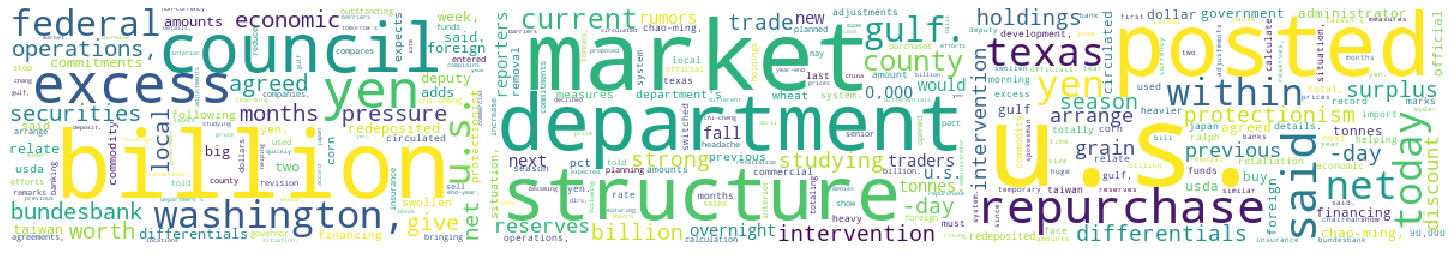

=============================EPOCH 1=============================
LDA assigned topic vs True topics in documents:
Topic 2 -> ['interest']
Topic 1 -> ['interest' 'money-fx']
Topic 1 -> ['corn' 'grain']
Topic 2 -> ['corn' 'grain' 'wheat']
Topic 2 -> ['reserves']
Topic 1 -> ['money-fx' 'reserves' 'trade']

LDA assigned best words in topics:
Topic 0 -> ['net' 'amounts' 'bundesbank']
Topic 1 -> ['studying' 'measures' 'reserves']
Topic 2 -> ['reserves' 'said.' 'u.s.']

Expected topic distribution
[[0.244419 0.320396 0.435185]
 [0.313667 0.349356 0.336978]
 [0.252205 0.471992 0.275804]
 [0.319004 0.290274 0.390722]
 [0.268529 0.307356 0.424115]
 [0.278203 0.363167 0.358629]]
====================Wordcloud animation for word distribution in each topic====================


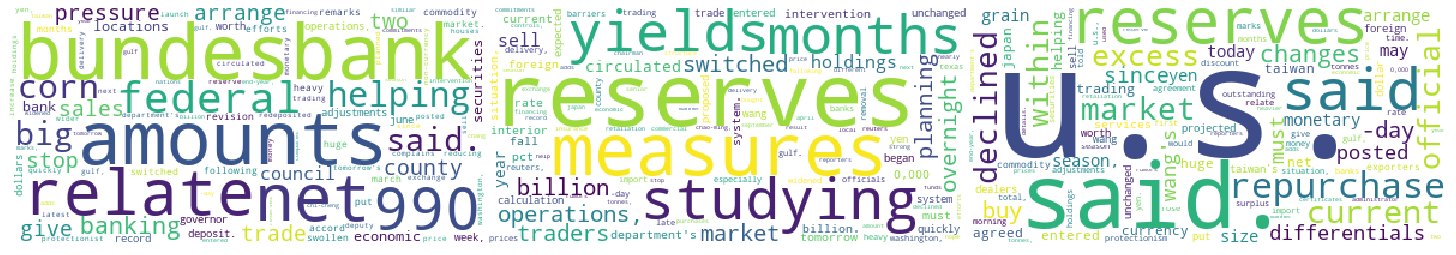

=============================EPOCH 2=============================
LDA assigned topic vs True topics in documents:
Topic 1 -> ['interest']
Topic 0 -> ['interest' 'money-fx']
Topic 0 -> ['corn' 'grain']
Topic 1 -> ['corn' 'grain' 'wheat']
Topic 2 -> ['reserves']
Topic 0 -> ['money-fx' 'reserves' 'trade']

LDA assigned best words in topics:
Topic 0 -> ['trading' 'week,' 'u.s.']
Topic 1 -> ['fed' 'reserves' 'billion']
Topic 2 -> ['net' 'reserves' 'said.']

Expected topic distribution
[[0.343252 0.442075 0.214673]
 [0.412741 0.306399 0.280859]
 [0.356471 0.341822 0.301707]
 [0.289815 0.449695 0.260489]
 [0.119085 0.387235 0.49368 ]
 [0.347745 0.336716 0.315539]]
====================Wordcloud animation for word distribution in each topic====================


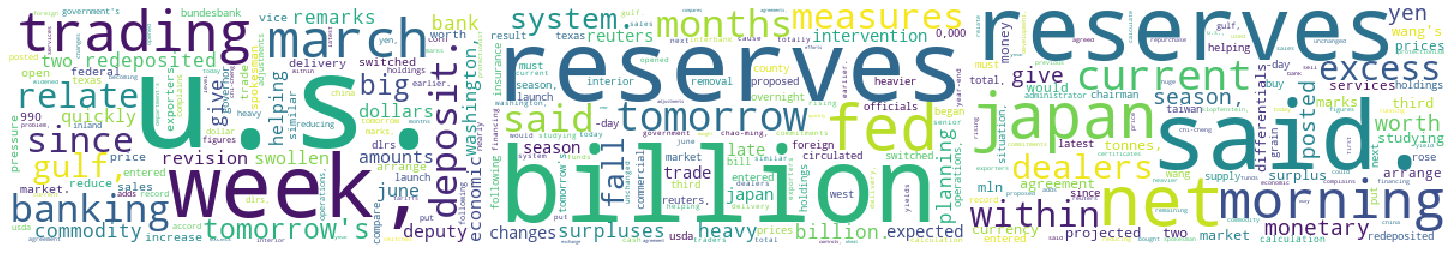

In [43]:
NO_EPOCHS=3
DYN_NO_SAMPLES=int(MASTER_MCMC_SAMPLE / 5)

dyn_corpus = CorpusTokenizer(pDF, NO_TOPICS, NO_DOCUMENTS).sample_topics().sample_documents().tokenize()

# Build the DYN document
dyn_model = DYN(NO_EPOCHS, dyn_corpus).build()
# Sample it
dyn_sampler = DYNSampler(dyn_model)
dyn_sampler.sample(DYN_NO_SAMPLES, False)

# Get results for each time interval
for i, sampler in enumerate(dyn_sampler.samplers):
    print('=============================EPOCH {}============================='.format(i))
    dyn_analizer = LDAAnalizer(sampler)
    dyn_analizer._no_best_words = 5
    dyn_analizer.print_document_topic_distribution().show_wordcloud_topic_word_distribution()